## Victorial Era Authorship Attribution ##

This notebook demonstrates the use of stylometry-toolkit to build a simple authorship attribution
classifier using a supervised learning approach. We will be working with a fairly large dataset so
I would recommend using Colab or a similar cloud platform.

To run this notebook in Colab, clone the repository, copy to your Google Drive and adjust the paths
in the cell below as required.

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/Colab Notebooks/stylometry-toolkit
sys.path.append('/content//drive/MyDrive/Colab Notebooks/sylometry-toolkit')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from stylometry import TextDataset, TextSample

The [Victorian Era Authorship Attribution](https://archive.ics.uci.edu/dataset/454/victorian+era+authorship+attribution)
dataset from the UCI Machine Learning Archive includes over 90000 text samples from 50 well known (but unnamed) Victorian era novelists. For the purpose of this demo and to keep filesizes manageable, I have included a csv file containing the first 15 authors only.

In [ ]:
text_dataset = pd.read_csv('victorian-authors.csv')
text_dataset.head()

,text,author
0,ou have time to listen i will give you the ent...,1
1,wish for solitude he was twenty years of age a...,1
2,and the skirt blew in perfect freedom about th...,1
3,of san and the rows of shops opposite impresse...,1
4,an hour s walk was as tiresome as three in a s...,1


The text samples consist only of lower case letters, all other symbols including numbers were removed by the original creators of the dataset. Additional text preprocessing removed infrequently occuring words, retaining only the top 10,000 distinct words

Each sample is 1000 words long and, unfortunately, there are a variable number of text samples per author. To keep things simple, we will randomly select 5 writers and randomly sample an equal number of texts from each author.

In [ ]:
no_of_authors = 5

# randomly sample required number of authors
author_list = text_dataset['author'].sample(no_of_authors, replace=False).values

# extract the texts by these randomly chosen authors
bool_mask = text_dataset['author'].isin(author_list)
data = text_dataset[bool_mask]
data.head(), data.tail()

(                                                   text  author
 1507  in her lips that were parted just then in a of...       4
 1508  as her unwelcome by the fa te of coach fellow ...       4
 1509  but i never told you what the accident was he ...       4
 1510  through the gray smoke of his he had as from s...       4
 1511  and moved away so rapidly that s why my dear b...       4,
                                                     text  author
 12169  be called its going for instance southward or ...      10
 12170  the beauty of a great work of architecture is ...      10
 12171  and pr turning first to the west through a cou...      10
 12172  by the universal s bow mouth and trying to see...      10
 12173  church but one receives in narrow glimpses thr...      10)

In [ ]:
# this dataset is not balanced. There are many more
# examples of some authors writing than others

counts = data['author'].value_counts()
counts

8     6914
4     1483
9     1108
10     755
Name: author, dtype: int64

In [ ]:
# find the class smallest number of texts

#no_to_sample = counts.min()

# or, for the purposes of this demonstration simply select
# a number, greater than or equal to the minimum

no_to_sample = 250

sampled_list = []

# sample this number of texts from each
# author to ensure a balanced dataset
for i in counts.index:
  sampled_list.append( (data[ data['author'] == i]).sample(no_to_sample) )

data = pd.concat(sampled_list)
data.head(), data.tail()

(                                                   text  author
 9524  certainly the footman had so had the sight of ...       8
 7523  than mine i should be sorry that you went away...       8
 6715  know her not neither why they first kept compa...       8
 7835  is a dreadful thought said turning pale it m a...       8
 7194  so uncomfortable i wouldn t have occasioned hi...       8,
                                                     text  author
 11701  each other do you know she told me she had the...      10
 12107  she needed relief â contrast â that was it she...      10
 12111  it for hours in there â yet she made a faint s...      10
 11836  both â our long sad sweet the joy of living dr...      10
 11521  such a would have their past â it would have b...      10)

We now have 250 text samples from four different authors and can build our TextDataset object

In [ ]:
text_sample_list = []

# for each row in the dataframe, build a TextSample object

for row in data.iterrows():
  text = row[1]['text']
  label = row[1]['author']
  text_sample_list.append( TextSample(text,label) )

# collate the list of text samples into a TextDataset
dataset = TextDataset(*text_sample_list)
dataset.X.head()

,a,b,c,d,e,f,g,h,i,j,...,z,za,ze,zi,zl,zo,zy,zz,â,ž
0,0.023233,0.008200,0.006248,0.007614,0.002733,0.006638,0.004100,0.011714,0.016205,0.000586,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000586,0.0
1,0.025114,0.008717,0.008095,0.005189,0.002491,0.006227,0.002906,0.014944,0.017227,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.001660,0.0
2,0.029412,0.009267,0.006446,0.005238,0.004633,0.002417,0.002820,0.018533,0.009468,0.000403,...,0.0,0.0,0.000201,0.000000,0.000000,0.0,0.0,0.000000,0.000403,0.0
3,0.021264,0.009721,0.008505,0.005063,0.003038,0.004050,0.002633,0.014581,0.017618,0.000405,...,0.0,0.0,0.000203,0.000203,0.000000,0.0,0.0,0.000000,0.000810,0.0
4,0.024094,0.007414,0.004530,0.006178,0.003295,0.008031,0.005148,0.022858,0.016269,0.001236,...,0.0,0.0,0.000000,0.000206,0.000206,0.0,0.0,0.000206,0.000618,0.0


There is little, if any, consensus in the linguistics community as to what sort of features have the most explanatory power for authorship attribution. Whilst character n-grams appear to work well, the most suitable value of n depends on a range of factors including language, size of the character set (whether we have symbols/digits) and the amount of text available.

I have quite arbitrarily chosen to use the 250 most frequently occuring 3-grams and to use relative frequencies rather than counts.

We can reset our TextDataset to express the text samples this way.

In [ ]:
# reset the TextData object to display the 250 most
# frequent 3-grams

dataset(n=3, most_frequent = 250)
dataset.X.head()

,th,the,he,nd,an,and,ed,er,to,he,...,n o,so,te,een,ate,und,s b,oug,ell,rom
0,0.015427,0.011912,0.009178,0.005858,0.006249,0.004491,0.007811,0.009764,0.010154,0.005077,...,0.000976,0.000781,0.000391,0.001172,0.000586,0.001172,0.001367,0.000976,0.000195,0.001172
1,0.020760,0.013909,0.015985,0.008927,0.010172,0.009550,0.011625,0.004152,0.005190,0.006228,...,0.001868,0.000623,0.001038,0.000830,0.000830,0.000415,0.000623,0.000415,0.001246,0.001246
2,0.019545,0.014910,0.015716,0.008060,0.009470,0.008060,0.009672,0.005239,0.006851,0.007052,...,0.000806,0.001007,0.000806,0.000604,0.000806,0.000806,0.001209,0.001209,0.001007,0.000403
3,0.019850,0.015191,0.012963,0.009317,0.008305,0.008305,0.009317,0.007292,0.008102,0.005266,...,0.001013,0.000405,0.000000,0.001215,0.000810,0.000810,0.001013,0.001013,0.000000,0.000000
4,0.015654,0.008651,0.014418,0.008857,0.009063,0.007621,0.008033,0.006591,0.007209,0.009475,...,0.000412,0.001236,0.000000,0.000000,0.000618,0.000412,0.001236,0.000000,0.001236,0.000618


Now, we split the dataset into test and train sets using scikit-learn.

I have decided (once again, arbitrarily) to use a radial basis kernel support vector machine classifier. Linear SVMs also work fairly well but demonstrate lower accuracy. As we shall see, this carefully curated dataset represents a good choice for demonstrating n-gram based authorship attribution as the text samples are, by design, seperable with respect to n-gram frequency.

In [ ]:
x_train, x_test, y_train, y_test = tts(dataset.X, dataset.Y, test_size=0.2)

In [ ]:
# an rbf or polynomal kernel SVM seems to work best

model = SVC(kernel='rbf')

# initial parameter grid ranges C=(0.5,10) and g=(0.1,1)
# chosen purely at random - an initial guess

candidate_params = {'C' : np.linspace(0.5,5,10),
                    'gamma' : np.linspace(0.01,1,10)}

search = GridSearchCV(model,candidate_params,cv=3)
search.fit(x_train,y_train.values.flatten())

print(f'C: {search.best_params_["C"]}   gamma: {search.best_params_["gamma"]}    best score {search.best_score_}')

C: 0.5   gamma: 0.01    best score 0.25999924905897703


An initial 3-fold CV grid search for the gamma and cost parameters did not yield good results. The SVM model default setting 'scale' uses a common heuristic to calculate a value for gamma that often works well.

I'll not attempt a more extenstive and computationally expensive grid search but will fit a model using this default. 

In [ ]:
# gamma = 'scale' -> ( no_features * var(X) )^-1
# this may work better than optimal grid search params

model = SVC(kernel='rbf', gamma = 'scale')
model.fit(x_train,y_train.values.flatten())

train_preds = model.predict(x_train)
test_preds = model.predict(x_test)

print(f'Training Set Accuracy {f1_score(train_preds,y_train, average="micro")}')
print(f'Test Set Accuracy { f1_score(test_preds,y_test, average="micro") }')
print(f'F1 score {f1_score(y_test, test_preds,  average = "macro")}')
print(f'Gamma {model._gamma}')

Training Set Accuracy 0.92375
Test Set Accuracy 0.895
F1 score 0.8955300181363569
Gamma 634.2911265395402


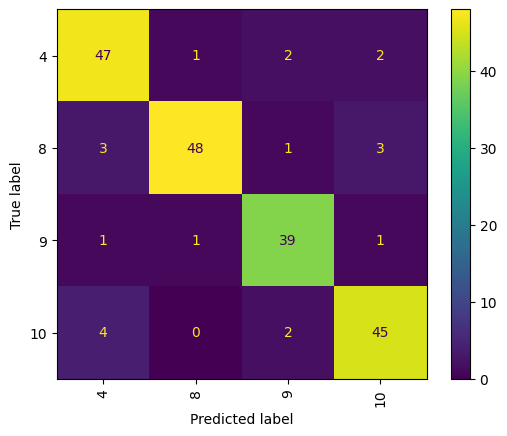

In [ ]:
labels = np.sort( y_test['label'].unique() )
confusion_plot = ConfusionMatrixDisplay( confusion_matrix(y_test, test_preds), display_labels = labels)
confusion_plot.plot(xticks_rotation=90);

The model successfully classified 179 out of 200 test set samples. The macro f1 score $\approx$ accuracy, so there is no evidence of differing accuracy between the 4 classes (as we can also see from the confusion matrix). For more discussion around multiclass classification metrics I have put together a brief explanatory document (**link tbc**).

It is perhaps quite remarkable that a feature set consisting of the relative frequencies of the 250 most commonly occuring character 3-grams can be used to distinguish between different writers at all, let alone with such accuracy. However, this is not always the case. My masters thesis researched the effectiveness of systems such as this for plagiarism detection using webscaped Guardian Newspaper articles as a proxy for student essays. In that case performace was far worse and a sequence based language modelling approach / a pretrained BERT Transformer Encoder was more appropriate. That work is covered [elsewhere](https://github.com/chriskward)